# Seldon Core V1

## Setup

In [ ]:
!curl -L https://istio.io/downloadIstio | ISTIO_VERSION=1.17.1 sh -

In [258]:
%%bash
./istio-1.17.1/bin/istioctl install --set profile=default -y
./istio-1.17.1/bin/istioctl verify-install


- Processing resources for Istio core.
✔ Istio core installed
- Processing resources for Istiod.
✔ Istiod installed
- Processing resources for Ingress gateways.
- Processing resources for Ingress gateways. Waiting for Deployment/istio-system/istio-ingressgat...
✔ Ingress gateways installed
- Pruning removed resources
✔ Installation completeMaking this installation the default for injection and validation.



Thank you for installing Istio 1.17.  Please take a few minutes to tell us about your install/upgrade experience!  https://forms.gle/hMHGiwZHPU7UQRWe9
1 Istio control planes detected, checking --revision "default" only
✔ HorizontalPodAutoscaler: istiod.istio-system checked successfully
✔ ClusterRole: istiod-clusterrole-istio-system.istio-system checked successfully
✔ ClusterRole: istiod-gateway-controller-istio-system.istio-system checked successfully
✔ ClusterRoleBinding: istiod-clusterrole-istio-system.istio-system checked successfully
✔ ClusterRoleBinding: istiod-gateway-controller-istio-system.istio-system checked successfully
✔ ConfigMap: istio.istio-system checked successfully
✔ Deployment: istiod.istio-system checked successfully
✔ ConfigMap: istio-sidecar-injector.istio-system checked successfully
✔ MutatingWebhookConfiguration: istio-sidecar-injector.istio-system checked successfully
✔ PodDisruptionBudget: istiod.istio-system checked successfully
✔ ClusterRole: istio-reader-c

In [256]:
%%bash

kubectl apply -f - <<EOF
apiVersion: networking.istio.io/v1beta1
kind: Gateway
metadata:
  name: seldon-gateway
  namespace: istio-system
spec:
  selector:
    app: istio-ingressgateway
    istio: ingressgateway
  servers:
    - hosts:
        - "*"
      port:
        name: http
        number: 80
        protocol: HTTP
EOF

gateway.networking.istio.io/seldon-gateway unchanged


In [232]:
!helm repo add seldon-charts https://seldonio.github.io/helm-charts

"seldon-charts" already exists with the same configuration, skipping


In [233]:
!helm repo update seldon-charts

Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "seldon-charts" chart repository
Update Complete. ⎈Happy Helming!⎈


In [250]:
!kubectl create ns seldon-system 

Error from server (AlreadyExists): namespaces "seldon-system" already exists


In [251]:
!helm upgrade seldon-core seldon-charts/seldon-core-operator \
    --version 1.18.2 \
    --namespace seldon-system \
    --set istio.enabled=true \
    --install

Release "seldon-core" does not exist. Installing it now.
NAME: seldon-core
LAST DEPLOYED: Tue Nov 12 17:44:18 2024
NAMESPACE: seldon-system
STATUS: deployed
REVISION: 1
TEST SUITE: None


### Run from image

In [335]:
%%bash
kubectl apply -f - << EOF
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: my-model
spec:
  protocol: v2
  predictors:
    - name: default
      graph:
        name: classifier
      componentSpecs:
        - spec:
            containers:
              - name: classifier
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
EOF

seldondeployment.machinelearning.seldon.io/my-model created


In [340]:
!curl -d '{"inputs": [{"name":"predict","datatype":"FP32","shape":[4,1],"data":[[1.0, 2.0, 5.0, 6.0]]}]}' \
   -X POST http://localhost:80/seldon/default/my-model/v2/models/test-model/infer \
   -H "Content-Type: application/json"

{"model_name":"test-model","id":"e3b2aa0e-1bcd-475f-a584-fe113ee1282b","parameters":{},"outputs":[{"name":"predict","shape":[1,1],"datatype":"FP32","parameters":{"content_type":"np"},"data":[14.0]}]}

### Chaining

In [367]:
%%bash
kubectl apply -f - << EOF
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: my-model
spec:
  protocol: v2
  predictors:
    - name: default
      graph:
        name: preprocessor
        children:
        - name: model
          children:
          - name: postprocessor
      componentSpecs:
        - spec:
            containers:
              - name: preprocessor
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
              - name: model
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
              - name: postprocessor
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
EOF

seldondeployment.machinelearning.seldon.io/my-model configured


In [371]:
!curl -d '{"inputs": [{"name":"predict","datatype":"FP32","shape":[4,1],"data":[[1.0, 2.0, 5.0, 6.0]]}]}' \
   -X POST http://localhost:80/seldon/default/my-model/v2/models/test-model/infer \
   -H "Content-Type: application/json"

{"status":{"code":500,"info":"Failed to convert kfserving response so it could be chained to new input","status":"FAILURE"}}

### Canary Deployment

In [ ]:
%%bash
kubectl apply -f - << EOF
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: my-model
spec:
  protocol: v2
  predictors:
    - name: default
      graph:
        name: preprocessor
        children:
        - name: model
          children:
          - name: postprocessor
      componentSpecs:
        - spec:
            containers:
              - name: preprocessor
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
              - name: model
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
              - name: postprocessor
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
      traffic: 75
    - name: canary
      graph:
        name: classifier
      componentSpecs:
        - spec:
            containers:
              - name: classifier
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
      traffic: 25
EOF

In [ ]:
!hey -q 2 -c 2 -z 3m -m POST \
    -T application/json \
    -d '{"inputs": [{"name":"predict","datatype":"FP32","shape":[1,1],"data":[1]}]}' \
    http://localhost:80/seldon/default/my-model/v2/models/test-model/infer

In [372]:
%%bash
kubectl apply -f - << EOF
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: my-model
spec:
  protocol: v2
  predictors:
    - name: default
      graph:
        name: preprocessor
        children:
        - name: model
          children:
          - name: postprocessor
      componentSpecs:
        - spec:
            containers:
              - name: preprocessor
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
              - name: model
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
              - name: postprocessor
                image: axsaucedo/mlserver:simplemodel-0.0.1.dev1
EOF

seldondeployment.machinelearning.seldon.io/my-model configured


### Setup Minio

In [272]:
%%bash
kubectl create ns minio-system
helm repo add minio https://charts.min.io/
helm repo update minio
helm upgrade minio minio/minio \
    --set resources.requests.memory=100Mi \
    --set replicas=1 \
    --set persistence.enabled=false \
    --set mode=standalone \
    --set rootUser=minioadmin,rootPassword=minioadmin \
    --set service.type=LoadBalancer \
    --install \
    --namespace minio-system

Error from server (AlreadyExists): namespaces "minio-system" already exists


"minio" already exists with the same configuration, skipping
Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "minio" chart repository
Update Complete. ⎈Happy Helming!⎈
Release "minio" has been upgraded. Happy Helming!
NAME: minio
LAST DEPLOYED: Tue Nov 12 18:18:42 2024
NAMESPACE: minio-system
STATUS: deployed
REVISION: 3
TEST SUITE: None
NOTES:
MinIO can be accessed via port 9000 on an external IP address. Get the service external IP address by:
kubectl get svc --namespace minio-system -l app=minio

Note that the public IP may take a couple of minutes to be available.

You can now access MinIO server on http://<External-IP>:9000. Follow the below steps to connect to MinIO server with mc client:

  1. Download the MinIO mc client - https://min.io/docs/minio/linux/reference/minio-mc.html#quickstart

  2. export MC_HOST_minio-local=http://$(kubectl get secret minio --namespace minio-system -o jsonpath="{.data.rootUser}" | base64 -

In [248]:
!mc config host add minio-seldon http://localhost:9000 minioadmin minioadmin

]11;?\Added `minio-seldon` successfully.


### Deploy Simple Config File from bucket

In [326]:
%%bash
kubectl apply -f - <<EOF
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: sklearn
spec:
  name: iris
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/v1.19.0-dev/sklearn/iris
      name: classifier
    name: default
    replicas: 1
EOF

seldondeployment.machinelearning.seldon.io/sklearn created


In [294]:
!curl -d '{"data": {"ndarray":[[1.0, 2.0, 5.0, 6.0]]}}' \
   -X POST http://localhost:80/seldon/default/sklearn/api/v1.0/predictions \
   -H "Content-Type: application/json"

{"data":{"names":["t:0","t:1","t:2"],"ndarray":[[9.912315378486718e-07,0.0007015931307743852,0.9992974156376878]]},"meta":{"requestPath":{"classifier":"seldonio/sklearnserver:1.18.2"}}}


In [334]:
%%bash
kubectl apply -f - << EOF
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
spec:
  name: resnet32
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: gs://seldon-models/triton/tf_cifar10
      name: cifar10
      type: MODEL
    name: default
    replicas: 1
  protocol: v2
EOF

seldondeployment.machinelearning.seldon.io/cifar10 created


### Upload local artifact

In [262]:
!mkdir -p sklearn/

In [263]:
# Original source code and more details can be found in:
# https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

SVC(gamma=0.001)

In [277]:
import joblib

model_file_name = "sklearn/model.joblib"
joblib.dump(classifier, model_file_name)

['sklearn/model.joblib']

In [278]:
!mc mb minio-seldon/mnist-svm -p

]11;?\Bucket created successfully `minio-seldon/mnist-svm`.


In [279]:
!mc cp sklearn/model.joblib minio-seldon/mnist-svm/

...del.joblib: 337.25 KiB / 337.25 KiB  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓  7.94 MiB/s 0s

In [275]:
%%bash
kubectl apply -f - <<EOF
apiVersion: v1
kind: Secret
metadata:
  name: seldon-init-container-secret
type: Opaque
stringData:
  RCLONE_CONFIG_S3_TYPE: s3
  RCLONE_CONFIG_S3_PROVIDER: minio
  RCLONE_CONFIG_S3_ACCESS_KEY_ID: minioadmin
  RCLONE_CONFIG_S3_SECRET_ACCESS_KEY: minioadmin
  RCLONE_CONFIG_S3_ENDPOINT: http://minio.minio-system.svc.cluster.local:9000
  RCLONE_CONFIG_S3_ENV_AUTH: "false"
EOF

secret/seldon-init-container-secret created


In [328]:
%%bash
kubectl apply -f - <<EOF
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: mnist-svm
spec:
  name: mnist-svm
  protocol: v2
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      name: classifier
      modelUri: s3://mnist-svm
      envSecretRefName: seldon-init-container-secret
    name: default
    replicas: 1
EOF

seldondeployment.machinelearning.seldon.io/mnist-svm configured


In [332]:
import requests

x_0 = X_test[0:1]
inference_request = {
    "inputs": [
        {
          "name": "predict",
          "shape": x_0.shape,
          "datatype": "FP32",
          "data": x_0.tolist()
        }
    ]
}

endpoint = "http://localhost:80/seldon/default/mnist-svm/v2/models/infer"
response = requests.post(endpoint, json=inference_request)

response.json()

{'model_name': 'classifier',
 'model_version': 'v1',
 'id': '0d4c5088-3086-4dd9-b5e5-d953903d7563',
 'parameters': {},
 'outputs': [{'name': 'predict',
   'shape': [1, 1],
   'datatype': 'INT64',
   'parameters': {'content_type': 'np'},
   'data': [8]}]}

# Seldon Core V2

## Setup 

In [5]:
!git clone https://github.com/SeldonIO/seldon-core --branch=v2

Cloning into 'seldon-core'...
remote: Enumerating objects: 161210, done.
remote: Counting objects: 100% (1254/1254), done.
remote: Compressing objects: 100% (772/772), done.
remote: Total 161210 (delta 642), reused 933 (delta 446), pack-reused 159956 (from 1)
Receiving objects: 100% (161210/161210), 236.29 MiB | 6.46 MiB/s, done.
Resolving deltas: 100% (100427/100427), done.


In [10]:
!uv add pip

Resolved 206 packages in 379ms                                       
⠸  (1/1)                                                                        Prepared 1 package in 460ms
Installed 1 package in 10ms                                 
 + pip==24.3.1


In [17]:
!uv pip install -r seldon-core/ansible/requirements.yml

pip install -r requirements.txt
ansible-galaxy install -r requirements.yml
Starting galaxy collection install process
Process install dependency map
[WARNING]: Skipping Galaxy server https://galaxy.ansible.com. Got an unexpected
error when getting available versions of collection kubernetes.core: Unknown
error when attempting to call Galaxy at 'https://galaxy.ansible.com/api/':
HTTPSConnection.__init__() got an unexpected keyword argument 'cert_file'.
HTTPSConnection.__init__() got an unexpected keyword argument 'cert_file'
ERROR! Unknown error when attempting to call Galaxy at 'https://galaxy.ansible.com/api/': HTTPSConnection.__init__() got an unexpected keyword argument 'cert_file'. HTTPSConnection.__init__() got an unexpected keyword argument 'cert_file'
make: *** [install_deps_stable] Error 1


In [18]:
!ansible-galaxy install -r seldon-core/ansible/requirements.yml

Starting galaxy collection install process
Process install dependency map
Starting collection install process
'kubernetes.core:2.4.0' is already installed, skipping.
Installing 'community.docker:3.10.4' to '/Users/asaucedo/.ansible/collections/ansible_collections/community/docker'
community.docker:3.10.4 was installed successfully
Installing 'community.library_inventory_filtering_v1:1.0.2' to '/Users/asaucedo/.ansible/collections/ansible_collections/community/library_inventory_filtering_v1'
community.library_inventory_filtering_v1:1.0.2 was installed successfully


In [31]:
# Required to avoid multiprocessor error in ansible
%env OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES 

env: OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES


In [32]:
!(cd seldon-core/ansible/ && ansible-playbook playbooks/setup-ecosystem.yaml)


PLAY [Setup Seldon Core 2 Ecosystem] *******************************************

TASK [Gathering Facts] *********************************************************
ok: [localhost]

TASK [Load vars from vars/default.yaml] ****************************************
ok: [localhost]

TASK [ecosystem : Create required k8s namespaces] ******************************
changed: [localhost] => (item=seldon-mesh)
ok: [localhost] => (item=seldon-mesh)

TASK [Install Prometheus Operator] *********************************************

TASK [prometheus : Create seldon-monitoring namespace if it doesn't exist] *****
changed: [localhost]

TASK [prometheus : Install Prometheus Operator] ********************************
changed: [localhost]

TASK [ecosystem : Create Seldon Core 2 PodMonitors] ****************************
changed: [localhost] => (item=prometheus/monitors/agent-podmonitor.yaml)
changed: [localhost] => (item=prometheus/monitors/envoy-servicemonitor.yaml)
changed: [localhost] => (item=prometheu

In [33]:
!(cd seldon-core/ansible/ && ansible-playbook playbooks/setup-seldon.yaml)


PLAY [Setup SCV2 Ecosystem] ****************************************************

TASK [Gathering Facts] *********************************************************
ok: [localhost]

TASK [Load vars from vars/default.yaml] ****************************************
ok: [localhost]

TASK [seldon : Apply defaults to seldon_dev] ***********************************
ok: [localhost]

TASK [seldon : Set default img_set keys] ***************************************
ok: [localhost]

TASK [seldon : Set default dev img_set keys] ***********************************
ok: [localhost]

TASK [seldon : Apply defaults to custom_image_config] **************************
skipping: [localhost]

TASK [seldon : Apply defaults to custom_image_repository] **********************
ok: [localhost] => (item=scheduler)
ok: [localhost] => (item=modelgateway)
ok: [localhost] => (item=pipelinegateway)
ok: [localhost] => (item=dataflow)
ok: [localhost] => (item=controller)
ok: [localhost] => (item=hodometer)
ok: [localhost] =

## Simple Model Example

In [49]:
%%bash
kubectl apply -n seldon-mesh -f - << EOF
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: iris
spec:
  storageUri: "gs://seldon-models/scv2/samples/mlserver_1.3.5/iris-sklearn"
  requirements:
  - sklearn
  memory: 100Ki
EOF

model.mlops.seldon.io/iris created


In [45]:
!kubectl get model -n seldon-mesh

NAME   READY   REPLICAS   AGE
iris   True    1          7m9s


In [46]:
!curl http://localhost:80/v2/models/iris/infer \
    -H "Content-Type: application/json" \
    -d '{"inputs": [{"name": "predict", "shape": [1, 4], "datatype": "FP32", "data": [[1, 2, 3, 4]]}]}' | jq

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   307  100   213  100    94  12786   5642 --:--:-- --:--:-- --:--:-- 19187
{
  "model_name": "iris_1",
  "model_version": "1",
  "id": "71d3f7b8-f48c-4aab-ae90-fd9071a4e9ca",
  "parameters": {},
  "outputs": [
    {
      "name": "predict",
      "shape": [
        1,
        1
      ],
      "datatype": "INT64",
      "parameters": {
        "content_type": "np"
      },
      "data": [
        2
      ]
    }
  ]
}


In [47]:
%%bash
kubectl apply -n seldon-mesh -f - << EOF
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: wine
spec:
  storageUri: "gs://seldon-models/scv2/samples/mlserver_1.3.5/wine-mlflow"
  requirements:
  - mlflow
EOF

model.mlops.seldon.io/wine created


In [50]:
!kubectl get -n seldon-mesh models 

NAME   READY   REPLICAS   AGE
iris   True    1          2s
wine   True    1          28s


In [52]:
import requests
url = "http://0.0.0.0:80/v2/models/model/infer"
inference_request = {
    "inputs": [
        {
          "name": "fixed acidity",
          "shape": [1],
          "datatype": "FP32",
          "data": [7.4],
        },
        {
          "name": "volatile acidity",
          "shape": [1],
          "datatype": "FP32",
          "data": [0.7000],
        },
        {
          "name": "citric acid",
          "shape": [1],
          "datatype": "FP32",
          "data": [0],
        },
        {
          "name": "residual sugar",
          "shape": [1],
          "datatype": "FP32",
          "data": [1.9],
        },
        {
          "name": "chlorides",
          "shape": [1],
          "datatype": "FP32",
          "data": [0.076],
        },
        {
          "name": "free sulfur dioxide",
          "shape": [1],
          "datatype": "FP32",
          "data": [11],
        },
        {
          "name": "total sulfur dioxide",
          "shape": [1],
          "datatype": "FP32",
          "data": [34],
        },
        {
          "name": "density",
          "shape": [1],
          "datatype": "FP32",
          "data": [0.9978],
        },
        {
          "name": "pH",
          "shape": [1],
          "datatype": "FP32",
          "data": [3.51],
        },
        {
          "name": "sulphates",
          "shape": [1],
          "datatype": "FP32",
          "data": [0.56],
        },
        {
          "name": "alcohol",
          "shape": [1],
          "datatype": "FP32",
          "data": [9.4],
        },
    ]
}
headers = {"Content-Type": "application/json", "seldon-model":"wine"}
response_raw = requests.post(url, json=inference_request, headers=headers)
print(response_raw.json())

{'model_name': 'wine_1', 'model_version': '1', 'id': '520c93cf-dae6-4aed-be3f-e7da70bf5e6e', 'parameters': {'content_type': 'np'}, 'outputs': [{'name': 'output-1', 'shape': [1, 1], 'datatype': 'FP64', 'parameters': {'content_type': 'np'}, 'data': [5.576883936610762]}]}


## View Analytics

Grafana dashboard for seldon mesh:

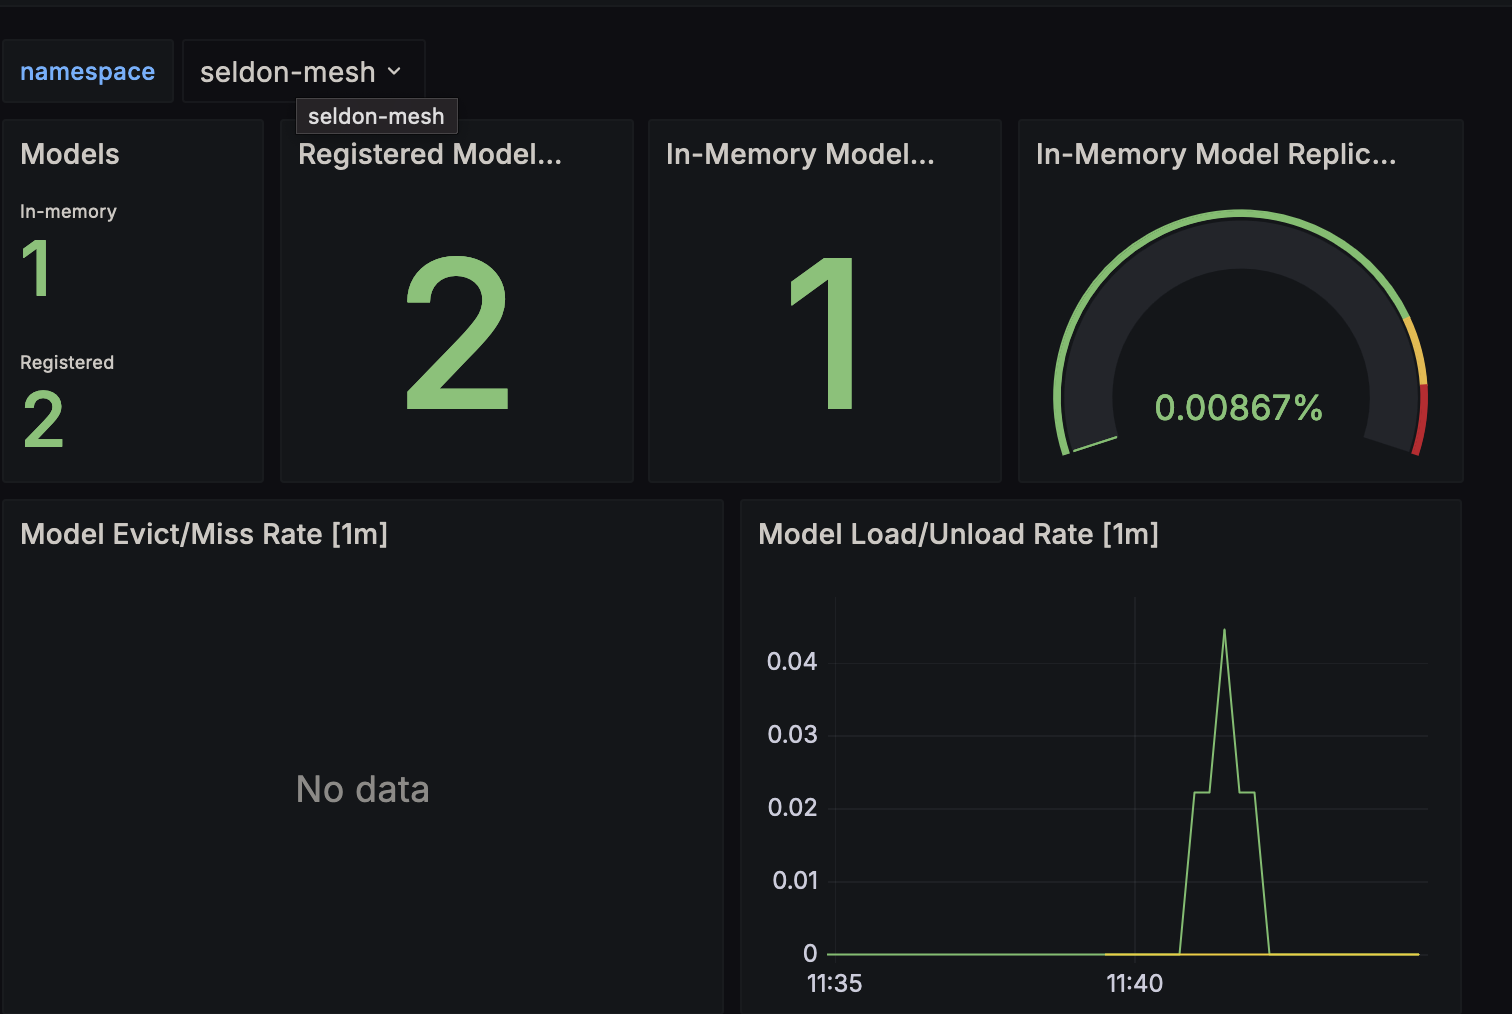

## Pipeline Example

In [132]:
%%bash
kubectl apply -n seldon-mesh -f - << EOF
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: income-preprocess
spec:
  storageUri: "gs://seldon-models/scv2/examples/mlserver_1.3.5/income/preprocessor"
  requirements:
  - sklearn
EOF

model.mlops.seldon.io/income-preprocess created


In [133]:
%%bash
kubectl apply -n seldon-mesh -f - << EOF
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: income
spec:
  storageUri: "gs://seldon-models/scv2/examples/mlserver_1.3.5/income/classifier"
  requirements:
  - sklearn
EOF

model.mlops.seldon.io/income created


In [174]:
%%bash
kubectl apply -n seldon-mesh -f - << EOF
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: income-drift
spec:
  storageUri: "gs://seldon-models/scv2/examples/mlserver_1.3.5/income/drift-detector"
  requirements:
    - mlserver
    - alibi-detect
EOF

model.mlops.seldon.io/income-drift created


In [109]:
%%bash
kubectl apply -n seldon-mesh -f - << EOF
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: income-outlier
spec:
  storageUri: "gs://seldon-models/scv2/examples/cifar10/outlier-detector"
  requirements:
    - mlserver
    - alibi-detect
EOF

model.mlops.seldon.io/income-outlier created


In [118]:
!kubectl get -n seldon-mesh models

NAME                READY   REPLICAS   AGE
income              False   1          85m
income-outlier      False   1          29m
income-preprocess   False   1          85m
iris                False   1          99m
wine                False   1          99m


In [175]:
!kubectl delete -n seldon-mesh model income income-drift income-outlier income-preprocess --force

model.mlops.seldon.io "income-drift" force deleted
Error from server (NotFound): models.mlops.seldon.io "income" not found
Error from server (NotFound): models.mlops.seldon.io "income-outlier" not found
Error from server (NotFound): models.mlops.seldon.io "income-preprocess" not found
